In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
try:
    plt.style.use("/Users/asludds/Dropbox/mplstyle.mplstyle")
except:
    plt.style.use("../../mplstyle.mplstyle")
from scipy.optimize import newton
from tqdm import tqdm

from SOA_model import SOA

In [2]:
class XPS():
    def __init__(self):
        #TODO: Update L_xps and ng_xps from a simulation
        #These values come fom Shashank's optimized dual XPS
        self.L_xps = 23.426e-6
        self.ng_xps = 4 #These values are very crude approximations right now, update them latter!
        self.intrinsic_loss_dB = 0.05

    def Pout_Pin(self,Pin):
        A,B,C,D = [-3.84490855, -1.62751586,  4.08981721,  1.02722676]
        # return A*Pin/(Pin**B+C) + D*Pin
        G = 50
        T = 0.07
        w = 0.5 - np.arctan(G*(Pin-T))/np.pi
        return Pin*w + A*Pin/(Pin**B+C) + D*Pin * (1-w)
    
    def plot_transmission(self):
        lin_power_sweep = np.linspace(1e-6,1,num=10000)
        lin_storage = np.array([self.Pout_Pin(i) for i in lin_power_sweep])
        plt.figure()
        plt.plot(lin_power_sweep,lin_storage)
        plt.show()

        plt.figure()
        plt.loglog(lin_power_sweep,lin_storage)
        plt.show()

class SiN_XPS_add_drop_ring_resonator():
    def __init__(self,kappa_squared,radius,propagation_loss_dB_m=2600):
        self.XPS = XPS()
        self.kappa = np.sqrt(kappa_squared)
        self.r = np.sqrt(1-kappa_squared)
        self.radius = radius
        self.propagation_loss_dB_m = propagation_loss_dB_m
        self.Lrt_SiN = 2 * np.pi * self.radius #The length of silicon nitride in a round trip
        self.ng = 1.98
        
        self.Lambda_res = 1310e-9
        self.a = np.exp(-self.propagation_loss_dB_m/(2*4.34) * self.Lrt_SiN) #Put in an initial guess of "a" that is just the loss from SiN
        self.Pwaveguide = 1e-5
        
        self.estimate_a_with_NLA() #Update a to include the effect of Finesse

    @property
    def Pwaveguide(self):
        return self._Pwaveguide
    
    @Pwaveguide.setter
    def Pwaveguide(self,value):
        self._Pwaveguide = float(value)
        self.estimate_a_with_NLA()

    def estimate_a_with_NLA(self):
        previous_a = 0
        next_a = 1000
        epsilon = 1e-6
        num_iterations = 0
        while abs(previous_a - next_a)/abs(next_a) > epsilon or num_iterations < 20: #A relative tolerance
            previous_a = next_a
            next_a = np.exp(-self.propagation_loss_dB_m/(2*4.34) * self.Lrt_SiN) * self.XPS.Pout_Pin(self.power_enhancement()*self.Pwaveguide)/(self.power_enhancement()*self.Pwaveguide) * 10**(-self.XPS.intrinsic_loss_dB/20) #Note the lack of a sqrt because of the two XPS
            num_iterations += 1
            self.a += (next_a - self.a)/10

    def transmission(self,phi=0):
        # Calculates transmission through ring. Assumes on resonance by default
        num = (1-self.r**2)*(1-self.r**2)*self.a
        denom = 1 - 2 * self.r**2 * self.a * np.cos(phi) + (self.r**2 * self.a)**2
        return num/denom 
    
    def Q(self):
        # The loaded quality factor for an add-drop ring resonator
        num = np.pi * (self.ng * self.Lrt_SiN + 2 * self.XPS.ng_xps * self.XPS.L_xps) * np.sqrt(self.r**2 *self.a)
        denom = self.Lambda_res * (1 - self.r**2 * self.a)
        return num/denom
    
    def FSR(self):
        return self.Lambda_res**2/(self.ng * self.Lrt_SiN + 2 * self.XPS.ng_xps * self.XPS.L_xps)
    
    def FWHM(self):
        return self.Lambda_res/self.Q()
    
    def Finesse(self):
        return self.FSR()/self.FWHM()
    
    def power_enhancement(self):
        return self.Finesse()/np.pi
    
    def wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        lambda_sweep = np.linspace(lambda_start,lambda_stop,num=num)
        phase_sweep = 2*np.pi * (lambda_sweep - self.Lambda_res)/self.FSR()
        transmission_storage = [self.transmission(phi=i) for i in phase_sweep]
        return lambda_sweep, np.array(transmission_storage)
    
class Vernier_rings_in_longitudinal_cavity():
    def __init__(self,L_long,kappa_squared,radius1,radius2,propagation_loss_dB_m=2600):
        self.ring1 = SiN_XPS_add_drop_ring_resonator(kappa_squared,radius1,propagation_loss_dB_m)
        self.ring2 = SiN_XPS_add_drop_ring_resonator(kappa_squared,radius2,propagation_loss_dB_m)
        self.Pwaveguide = 1e-5
        self.L_long = L_long

    @property
    def Pwaveguide(self):
        return self._Pwaveguide
    
    @Pwaveguide.setter
    def Pwaveguide(self,value):
        self._Pwaveguide = float(value)
        self.ring1.Pwaveguide = self._Pwaveguide
        self.ring2.Pwaveguide = self._Pwaveguide

    def transmission_through_vernier(self):
        return self.ring1.transmission() * self.ring2.transmission()
    
    def Lrt_eff(self):
        return 2*self.L_long + (0.5 + (1 - self.ring1.kappa**2)/(self.ring1.kappa**2))* (self.ring1.Lrt_SiN + 2 * self.ring1.XPS.L_xps) + (0.5 + (1 - self.ring2.kappa**2)/(self.ring2.kappa**2))* (self.ring2.Lrt_SiN + 2 * self.ring2.XPS.L_xps)
    
    def FSR_longitudinal(self):
        return self.ring1.Lambda_res**2/(self.ring1.ng * self.Lrt_eff())
    
    def Vernier_FSR(self):
        return self.ring1.FSR()*self.ring2.FSR()/abs(self.ring1.FSR() - self.ring2.FSR())
    
    def Vernier_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        return wavelengths, ring1_sweep * ring2_sweep
    
    def longitudinal_cavity_transmission(self, Lambda):
        R1 = 0.9 #Values are placeholders. The Q of this fabry-perot cavity doesn't matter for calculating SMSR
        R2 = 0.9
        T1 = 1 - R1
        T2 = 1 - R2
        length_of_longitudinal_cavity = self.Lrt_eff()/2 #Factor of two because the function calculates the round trip length
        phi_offset = 2*np.pi*self.ring1.ng*length_of_longitudinal_cavity/self.ring1.Lambda_res #Subtract a phase offset to have fabry-perot cavity on resonance at 1310nm
        phi = 2 * np.pi * self.ring1.ng * length_of_longitudinal_cavity/ Lambda - phi_offset
        num = -1 * np.sqrt(T1*T2) *  np.exp(-1j * phi)
        denom = 1 - np.sqrt(R1*R2) * np.exp(-2 * 1j * phi)
        H = num/denom
        return np.real(H * np.conj(H))

    def Vernier_with_longitudinal_wavelength_sweep(self,lambda_start=1308e-9,lambda_stop=1312e-9,num=1000):
        wavelengths, ring1_sweep = self.ring1.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        wavelengths, ring2_sweep = self.ring2.wavelength_sweep(lambda_start=lambda_start,lambda_stop=lambda_stop,num=num)
        long_cavity_sweep = np.array([self.longitudinal_cavity_transmission(i) for i in wavelengths])
        return wavelengths, ring1_sweep * ring2_sweep * long_cavity_sweep

Vernier FSR is 229.90387023569238 (nm)
Vernier FSR is 229.90387023569238 (nm)
Vernier FSR is 229.90387023569238 (nm)


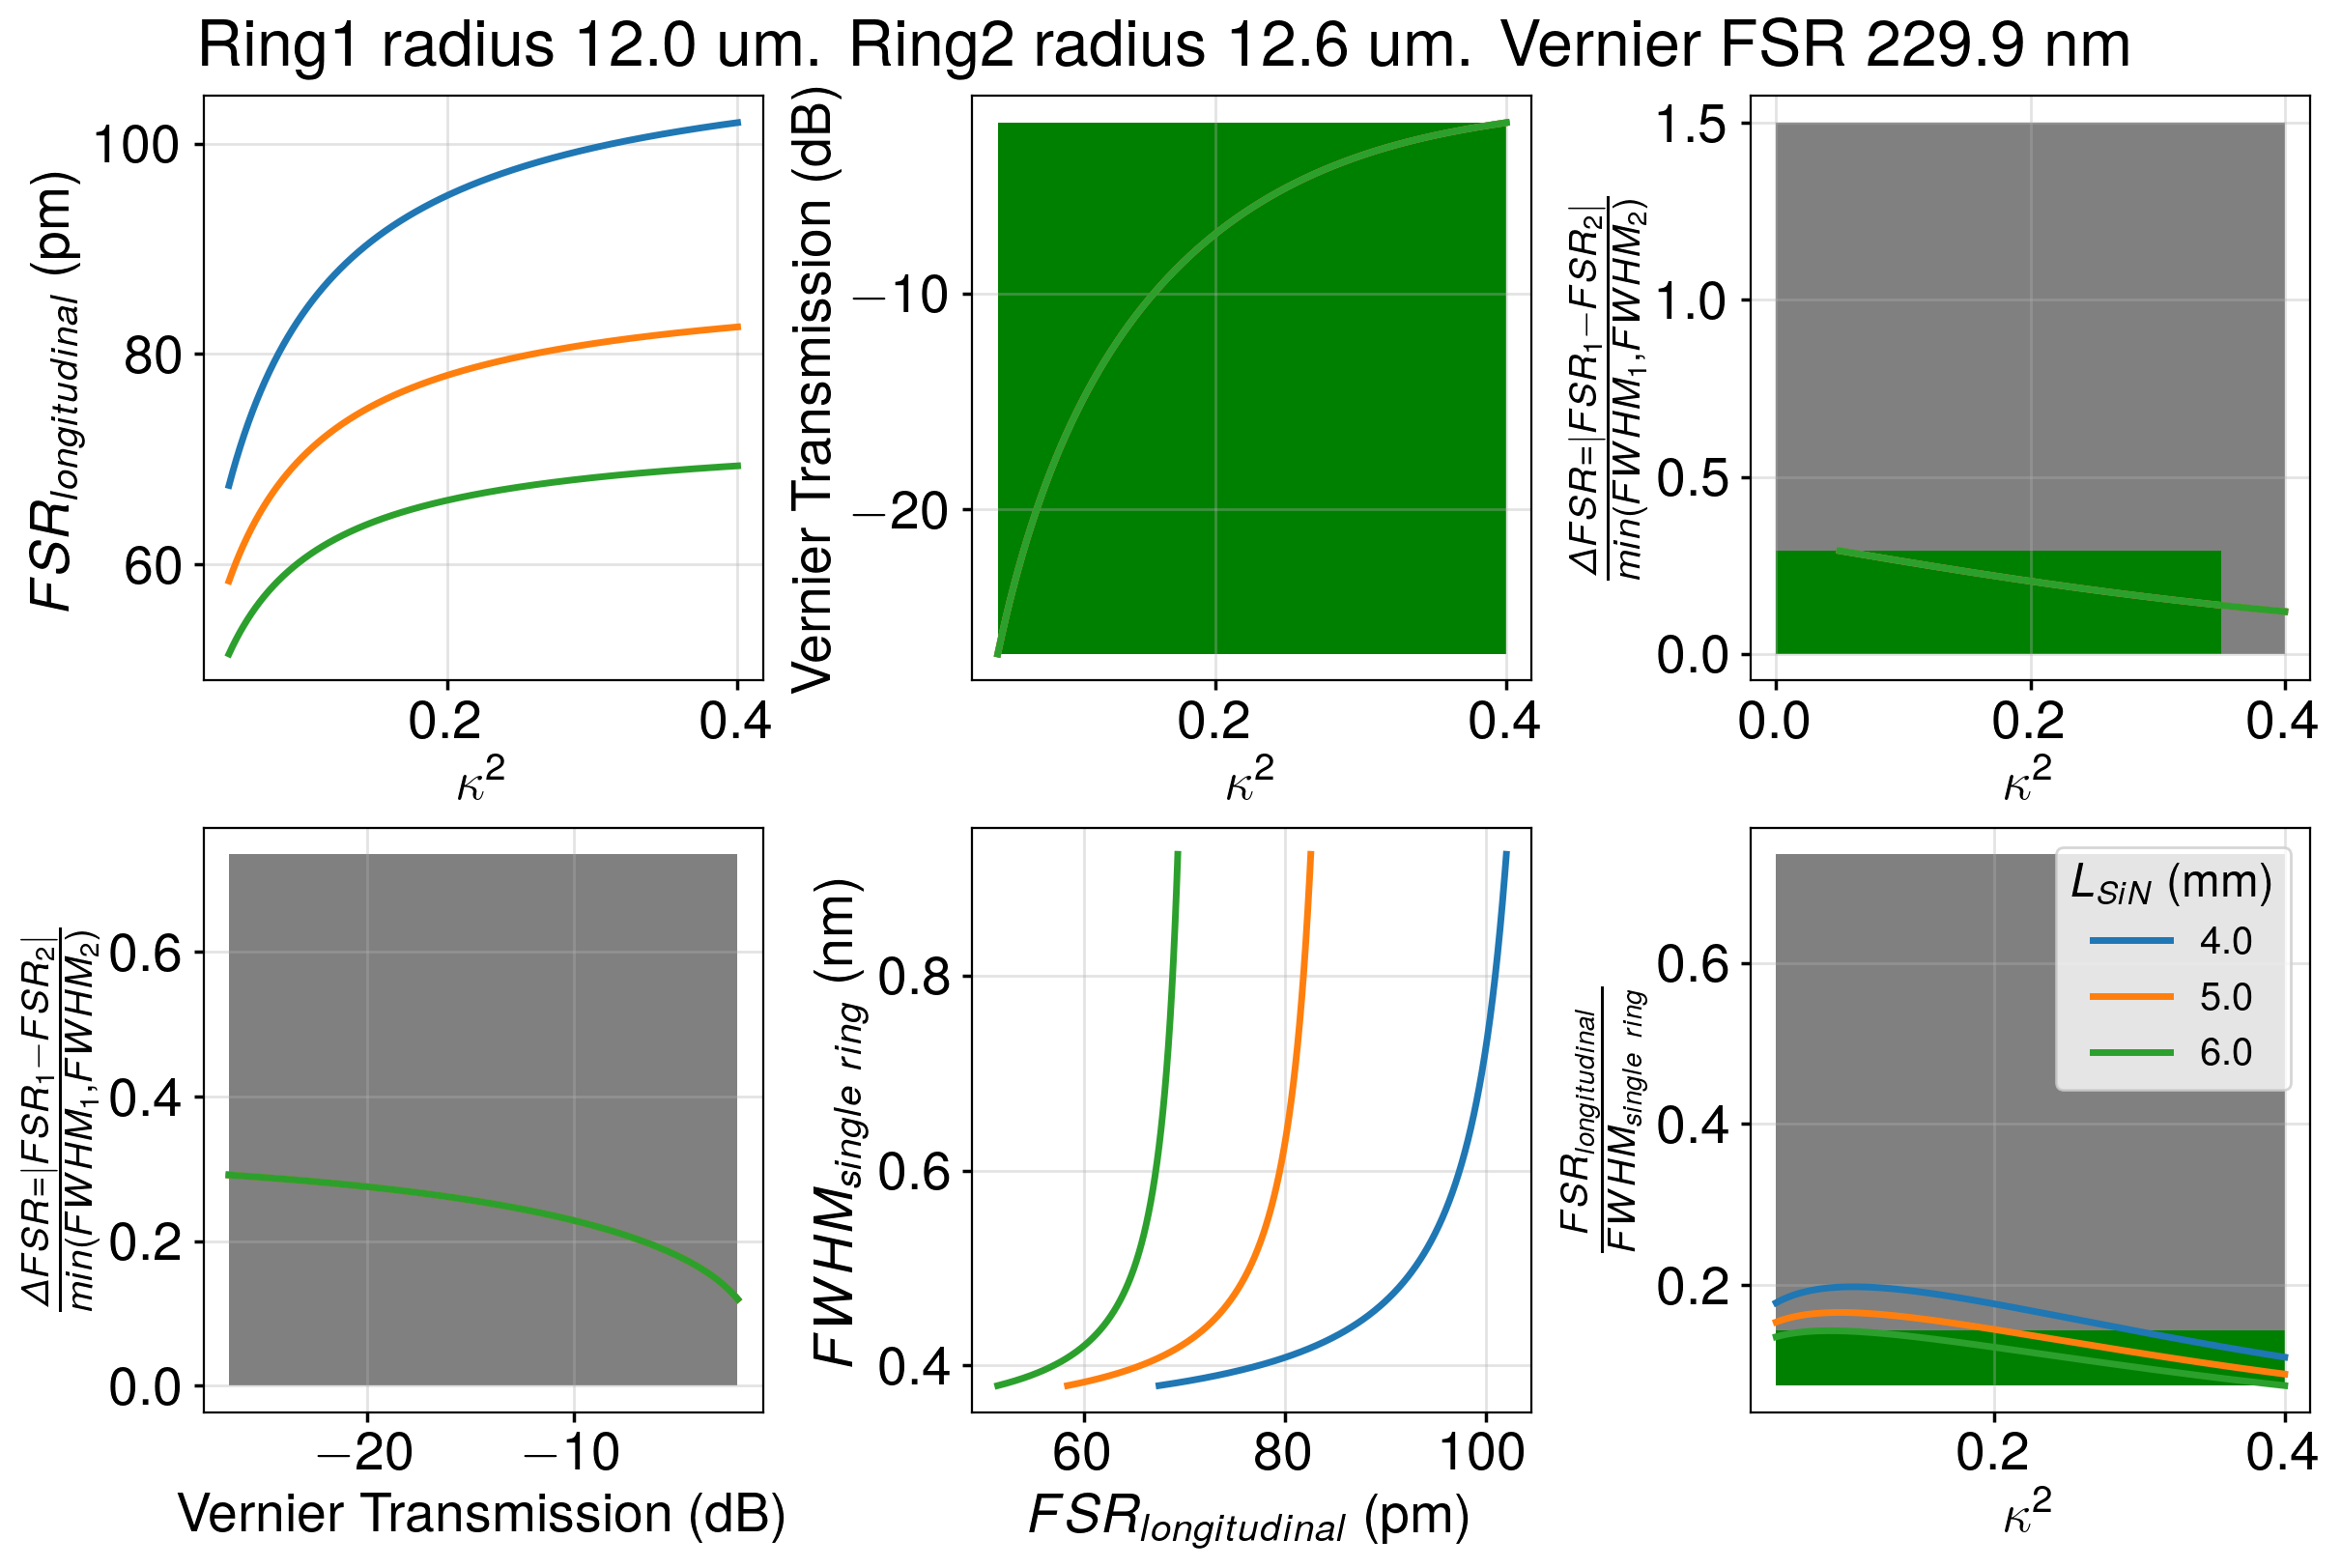

In [3]:
L_long_sweep = np.array([4e-3,5e-3,6e-3])
kappa_squared_sweep = np.linspace(0.05,0.4,num=1000)
r1 = 12e-6
r2 = 1.05*r1
highest_loss_allowed_dB = -0.8
vernier_delta_FSR_over_FWHM_bound = 1.5
longitudinal_delta_FSR_over_FWHM_bound = 0.735
fig,axs = plt.subplots(nrows=2,ncols=3,figsize=(12,8))
for L_long in L_long_sweep:
    transmission_storage = []
    FSR_storage = []
    min_ring_FWHM_storage = []
    delta_ring_FSR_storage = []
    for kappa_squared in kappa_squared_sweep:
        tmp = Vernier_rings_in_longitudinal_cavity(L_long,kappa_squared,r1,r2)
        tmp.Pwaveguide = 40e-3
        transmission_storage.append(tmp.transmission_through_vernier())
        FSR_storage.append(tmp.FSR_longitudinal())
        min_ring_FWHM_storage.append(min(tmp.ring1.FWHM(),tmp.ring2.FWHM()))
        delta_ring_FSR_storage.append(abs(tmp.ring1.FSR() - tmp.ring2.FSR()))

    print(f"Vernier FSR is {tmp.Vernier_FSR()*1e9} (nm)")
    kappa_highest_loss_allowed_index = np.argmin(np.abs(10*np.log10(transmission_storage) - highest_loss_allowed_dB))

    transmission_storage = np.array(transmission_storage)
    FSR_storage = np.array(FSR_storage)
    min_ring_FWHM_storage = np.array(min_ring_FWHM_storage)
    delta_ring_FSR_storage = np.array(delta_ring_FSR_storage)
    
    axs[0,0].plot(kappa_squared_sweep,FSR_storage*1e12)

    axs[0,1].plot(kappa_squared_sweep,10*np.log10(transmission_storage))
    axs[0,1].add_patch(matplotlib.patches.Rectangle(
        xy = (min(kappa_squared_sweep),min(10*np.log10(transmission_storage))),
        width = kappa_squared_sweep[kappa_highest_loss_allowed_index] - min(kappa_squared_sweep), 
        height = max(10*np.log10(transmission_storage)) - min(10*np.log10(transmission_storage)),
        facecolor="green",
        label='_nolegend_'))
    
    axs[0,2].plot(kappa_squared_sweep,delta_ring_FSR_storage/min_ring_FWHM_storage)
    axs[0,2].add_patch(matplotlib.patches.Rectangle((0,0), max(kappa_squared_sweep), vernier_delta_FSR_over_FWHM_bound, facecolor="grey",label='_nolegend_'))
    axs[0,2].add_patch(matplotlib.patches.Rectangle(
        xy = (0,0),
        width = kappa_squared_sweep[kappa_highest_loss_allowed_index] - min(kappa_squared_sweep), 
        height = max(delta_ring_FSR_storage/min_ring_FWHM_storage),
        facecolor="green",
        label='_nolegend_'))

    axs[1,0].plot(10*np.log10(transmission_storage),delta_ring_FSR_storage/min_ring_FWHM_storage)
    axs[1,0].add_patch(matplotlib.patches.Rectangle((min(10*np.log10(transmission_storage)),0), max(10*np.log10(transmission_storage)) - min(10*np.log10(transmission_storage)), longitudinal_delta_FSR_over_FWHM_bound, facecolor="grey",label='_nolegend_'))
    
    axs[1,1].plot(FSR_storage*1e12,min_ring_FWHM_storage*1e9)

    axs[1,2].plot(kappa_squared_sweep,FSR_storage/min_ring_FWHM_storage)
    axs[1,2].add_patch(matplotlib.patches.Rectangle((min(kappa_squared_sweep),min(FSR_storage/min_ring_FWHM_storage)), max(kappa_squared_sweep) - min(kappa_squared_sweep), longitudinal_delta_FSR_over_FWHM_bound - min(FSR_storage/min_ring_FWHM_storage), facecolor="grey",label='_nolegend_'))
    axs[1,2].add_patch(matplotlib.patches.Rectangle(
        xy = (min(kappa_squared_sweep),min(FSR_storage/min_ring_FWHM_storage)),
        width = kappa_squared_sweep[kappa_highest_loss_allowed_index] - min(kappa_squared_sweep), 
        height = max(FSR_storage/min_ring_FWHM_storage) - min(FSR_storage/min_ring_FWHM_storage),
        facecolor="green",
        label='_nolegend_'))

axs[0,0].set_xlabel(r"$\kappa^{2}$")
axs[0,0].set_ylabel(r"$FSR_{longitudinal}$ (pm)")

axs[0,1].set_xlabel(r"$\kappa^{2}$")
axs[0,1].set_ylabel("Vernier Transmission (dB)")

axs[0,2].set_xlabel(r"$\kappa^{2}$")
axs[0,2].set_ylabel(r"$\frac{\Delta FSR = |FSR_{1} - FSR_{2}|}{min(FWHM_{1},FWHM_{2})}$")

axs[1,0].set_xlabel("Vernier Transmission (dB)")
axs[1,0].set_ylabel(r"$\frac{\Delta FSR = |FSR_{1} - FSR_{2}|}{min(FWHM_{1},FWHM_{2})}$")

axs[1,1].set_xlabel(r"$FSR_{longitudinal}$ (pm)")
axs[1,1].set_ylabel(r"$FWHM_{single \ ring}$ (nm)")

axs[1,2].set_xlabel(r"$\kappa^{2}$")
axs[1,2].set_ylabel(r"$\frac{FSR_{longitudinal}}{FWHM_{single \ ring}}$")
axs[1,2].legend(L_long_sweep*1e3,title=r'$L_{SiN}$ (mm)')

# axs[1,2].set_xlim(0.045,0.06)

plt.suptitle(f"Ring1 radius {round(r1*1e6,2)} um. Ring2 radius {round(r2*1e6,2)} um. Vernier FSR {round(tmp.Vernier_FSR()*1e9,2)} nm")
plt.show()

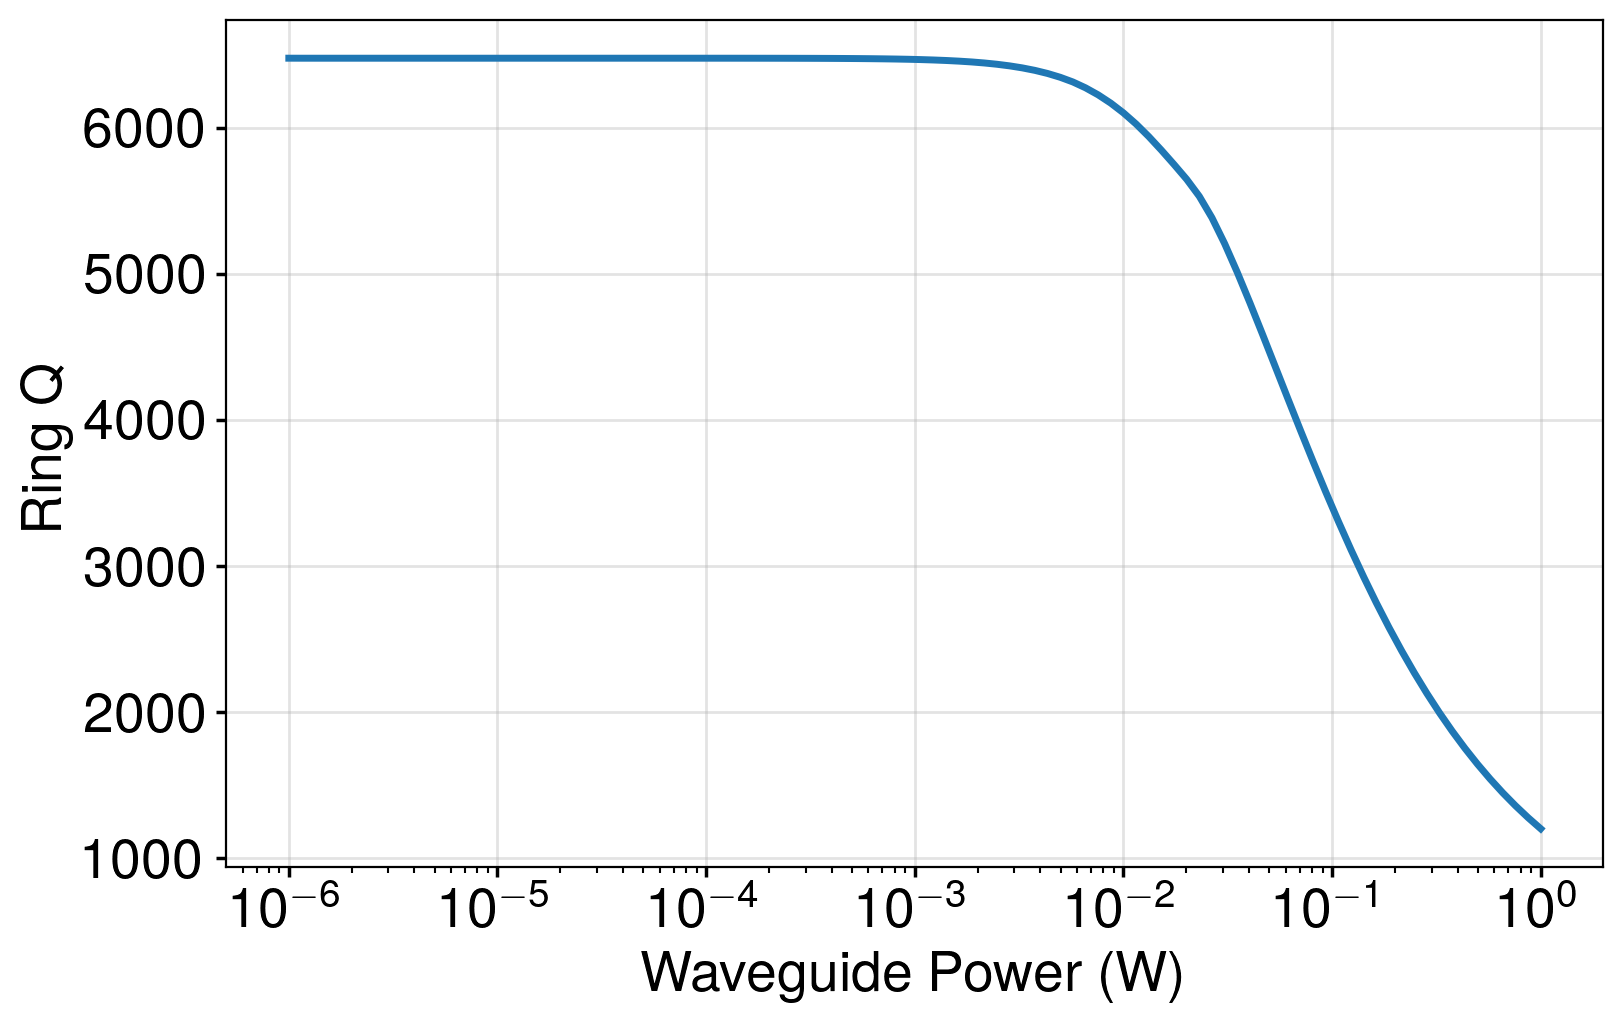

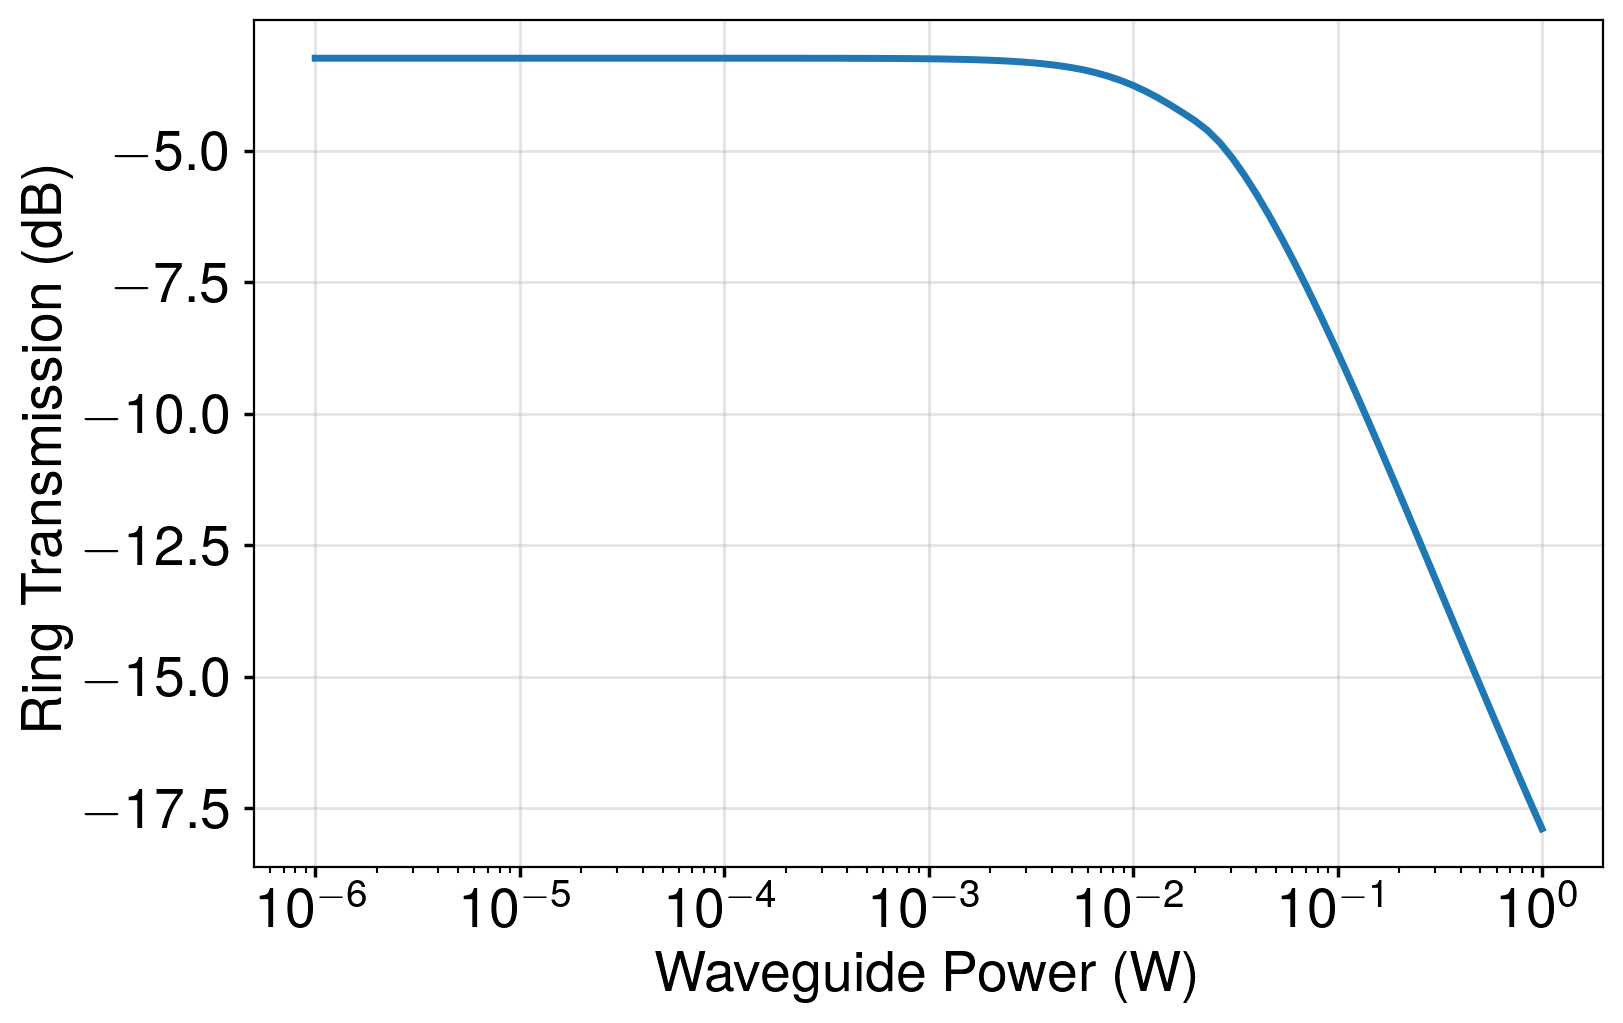

1200.2109041092504
0.730576032868921
2.5051228077982227e-09


In [4]:
tmp = SiN_XPS_add_drop_ring_resonator(kappa_squared=0.16,radius=40e-6)
# print(tmp.XPS.plot_transmission())

power_sweep = np.logspace(-6,0,base=10,num=100)
# power_sweep = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]
Q_storage = []
Finesse_storage = []
transmission_storage = []
ring_power_storage = []
for P in power_sweep:
    tmp.Pwaveguide = P
    Q_storage.append(tmp.Q())
    Finesse_storage.append(tmp.Finesse())
    transmission_storage.append(tmp.transmission())
    ring_power_storage.append(P*tmp.power_enhancement())

Q_storage = np.array(Q_storage)
Finesse_storage = np.array(Finesse_storage)
transmission_storage = np.array(transmission_storage)
ring_power_storage = np.array(ring_power_storage)

transmission_storage_dB = 10*np.log10(transmission_storage)

plt.figure()
plt.semilogx(power_sweep,Q_storage)
plt.xlabel("Waveguide Power (W)")
plt.ylabel("Ring Q")
plt.show()

plt.figure()
ax = plt.gca()
plt.semilogx(power_sweep,transmission_storage_dB)

plt.xlabel("Waveguide Power (W)")
plt.ylabel("Ring Transmission (dB)")
plt.show()

print(tmp.Q())
print(tmp.power_enhancement())
print(tmp.FSR())

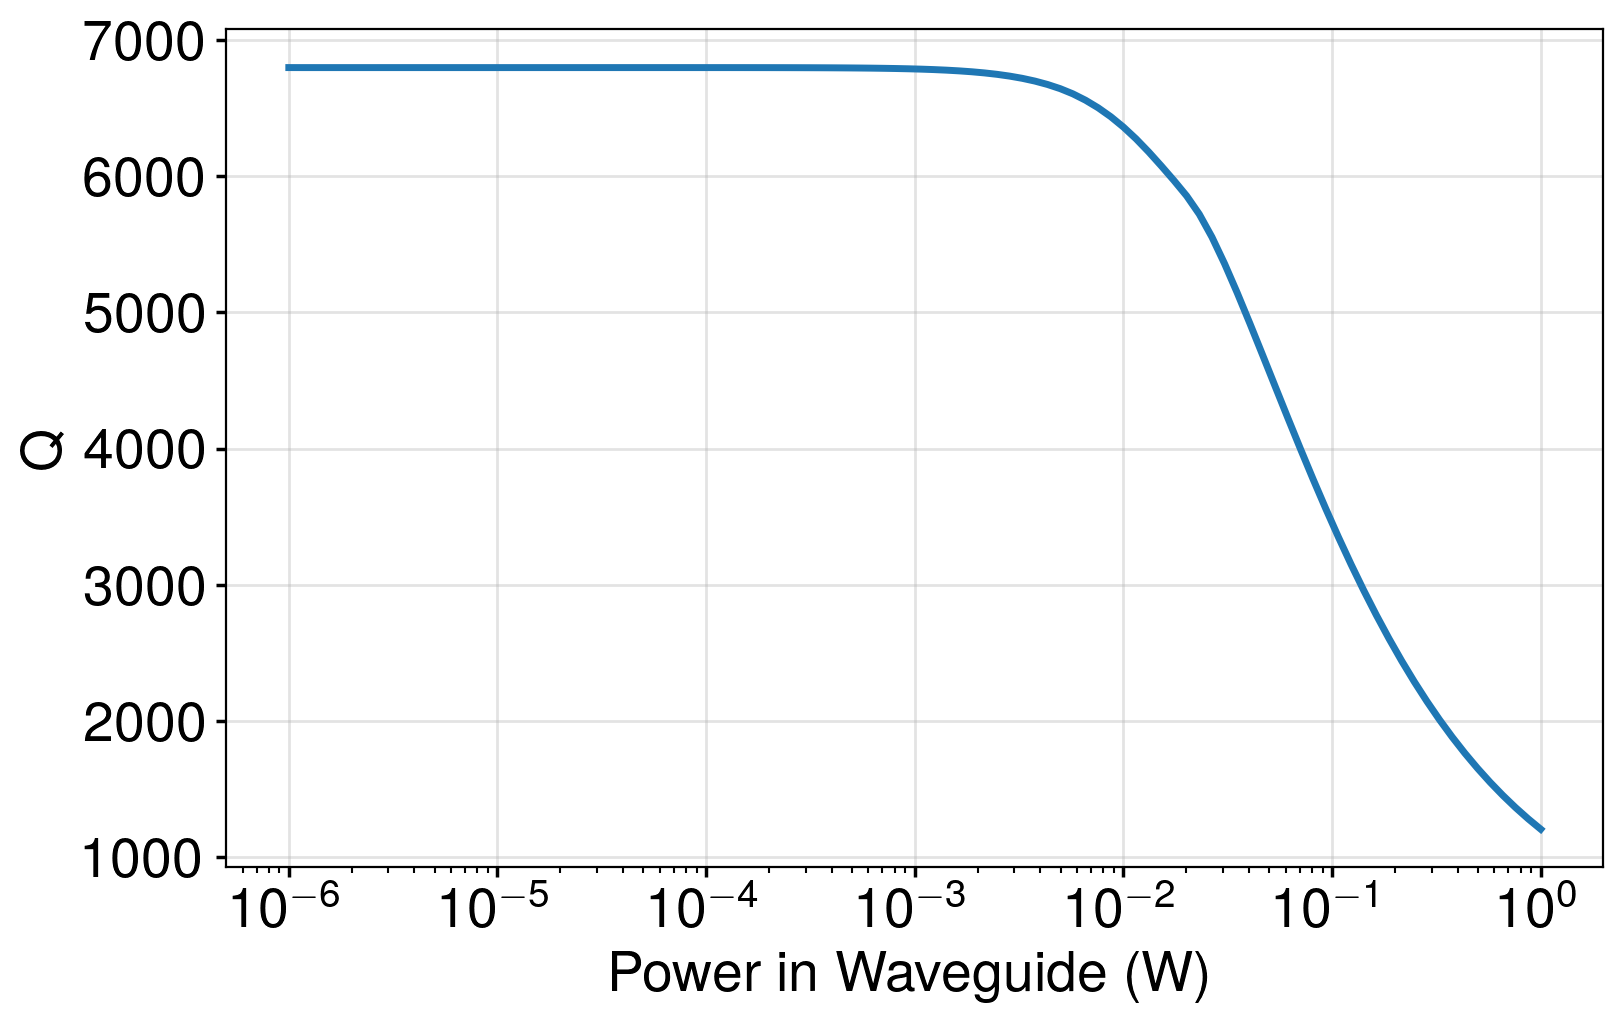

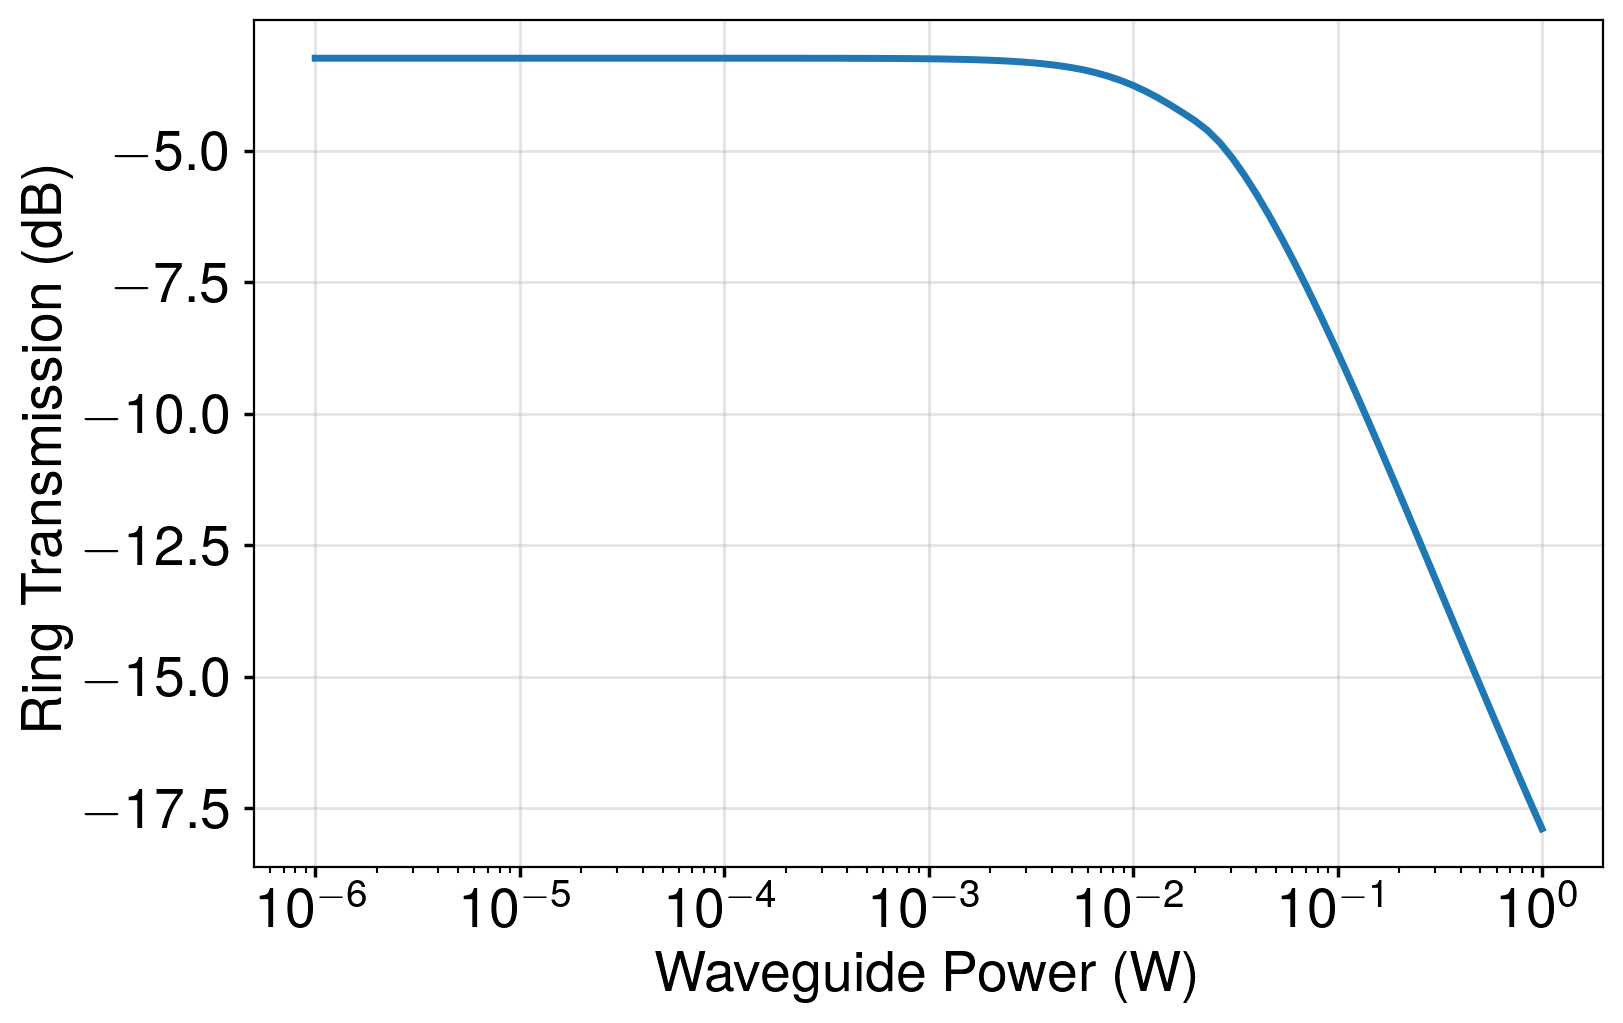

0.7130782086566305
2.5051228077982227e-09


In [5]:
radius_sweep = [40e-6]
power_sweep = np.logspace(-6,0,base=10,num=100)
# power_sweep = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]

plt.figure()
for r in radius_sweep:
    Q_storage = []
    tmp = SiN_XPS_add_drop_ring_resonator(kappa_squared=0.15,radius=r)
    for P in power_sweep:
        tmp.Pwaveguide = P
        Q_storage.append(tmp.Q())
    plt.semilogx(power_sweep,Q_storage)
plt.xlabel("Power in Waveguide (W)")
plt.ylabel("Q")
plt.show()

for r in radius_sweep:
    ring_power_storage = []
    tmp = SiN_XPS_add_drop_ring_resonator(kappa_squared=0.2,radius=r)
    for P in power_sweep:
        tmp.Pwaveguide = P
        ring_power_storage.append(P*tmp.power_enhancement())

Finesse_storage = np.array(Finesse_storage)
ring_power_storage = np.array(ring_power_storage)

transmission_storage_dB = 10*np.log10(transmission_storage)

plt.figure()
ax = plt.gca()
plt.semilogx(power_sweep,transmission_storage_dB)
plt.xlabel("Waveguide Power (W)")
plt.ylabel("Ring Transmission (dB)")
plt.show()


# print(tmp.Q())
print(tmp.power_enhancement())
print(tmp.FSR())

# 4mm Longitudinal Vernier Ring Mirror design

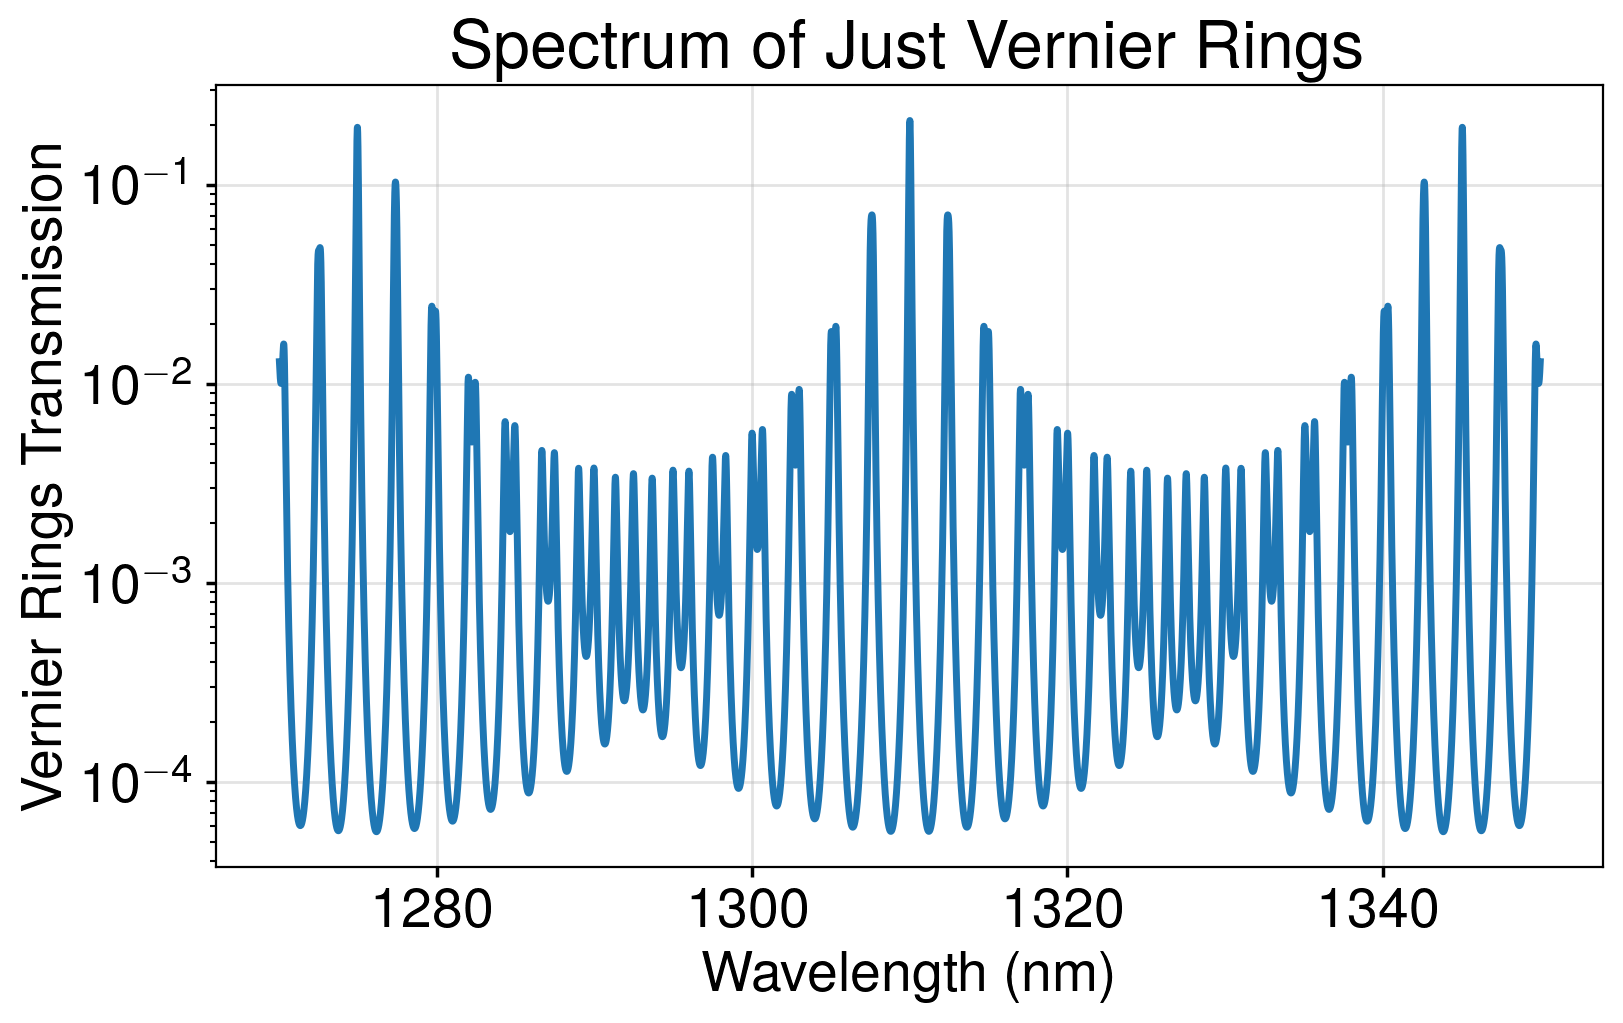

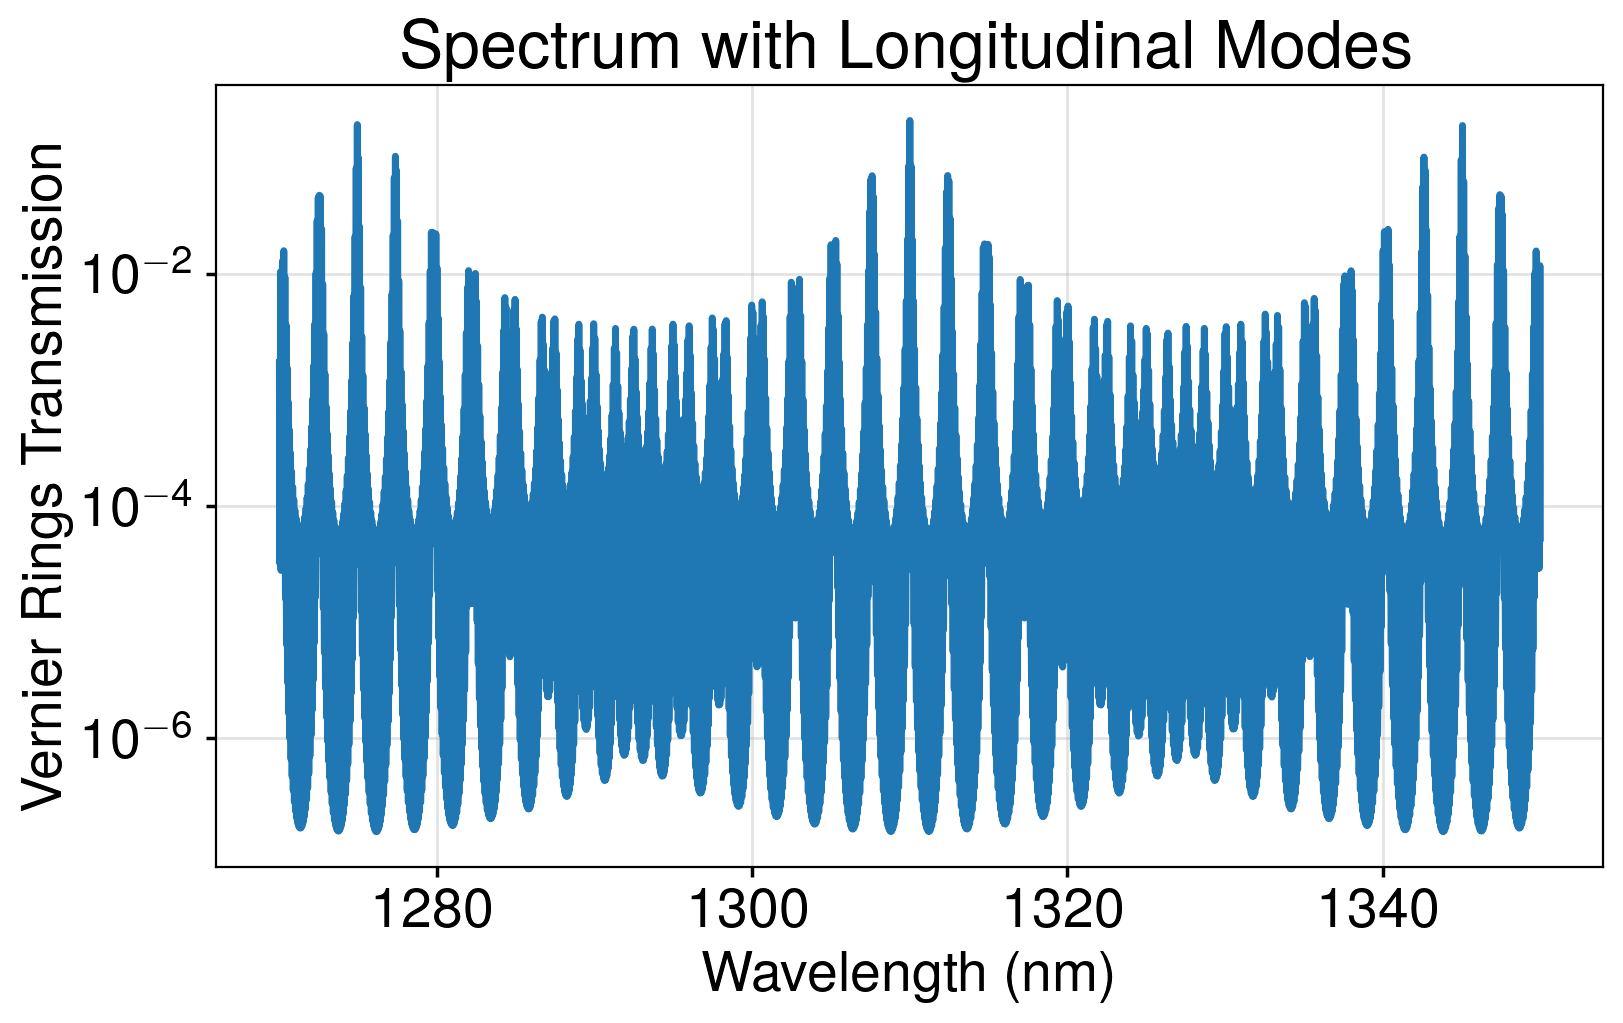

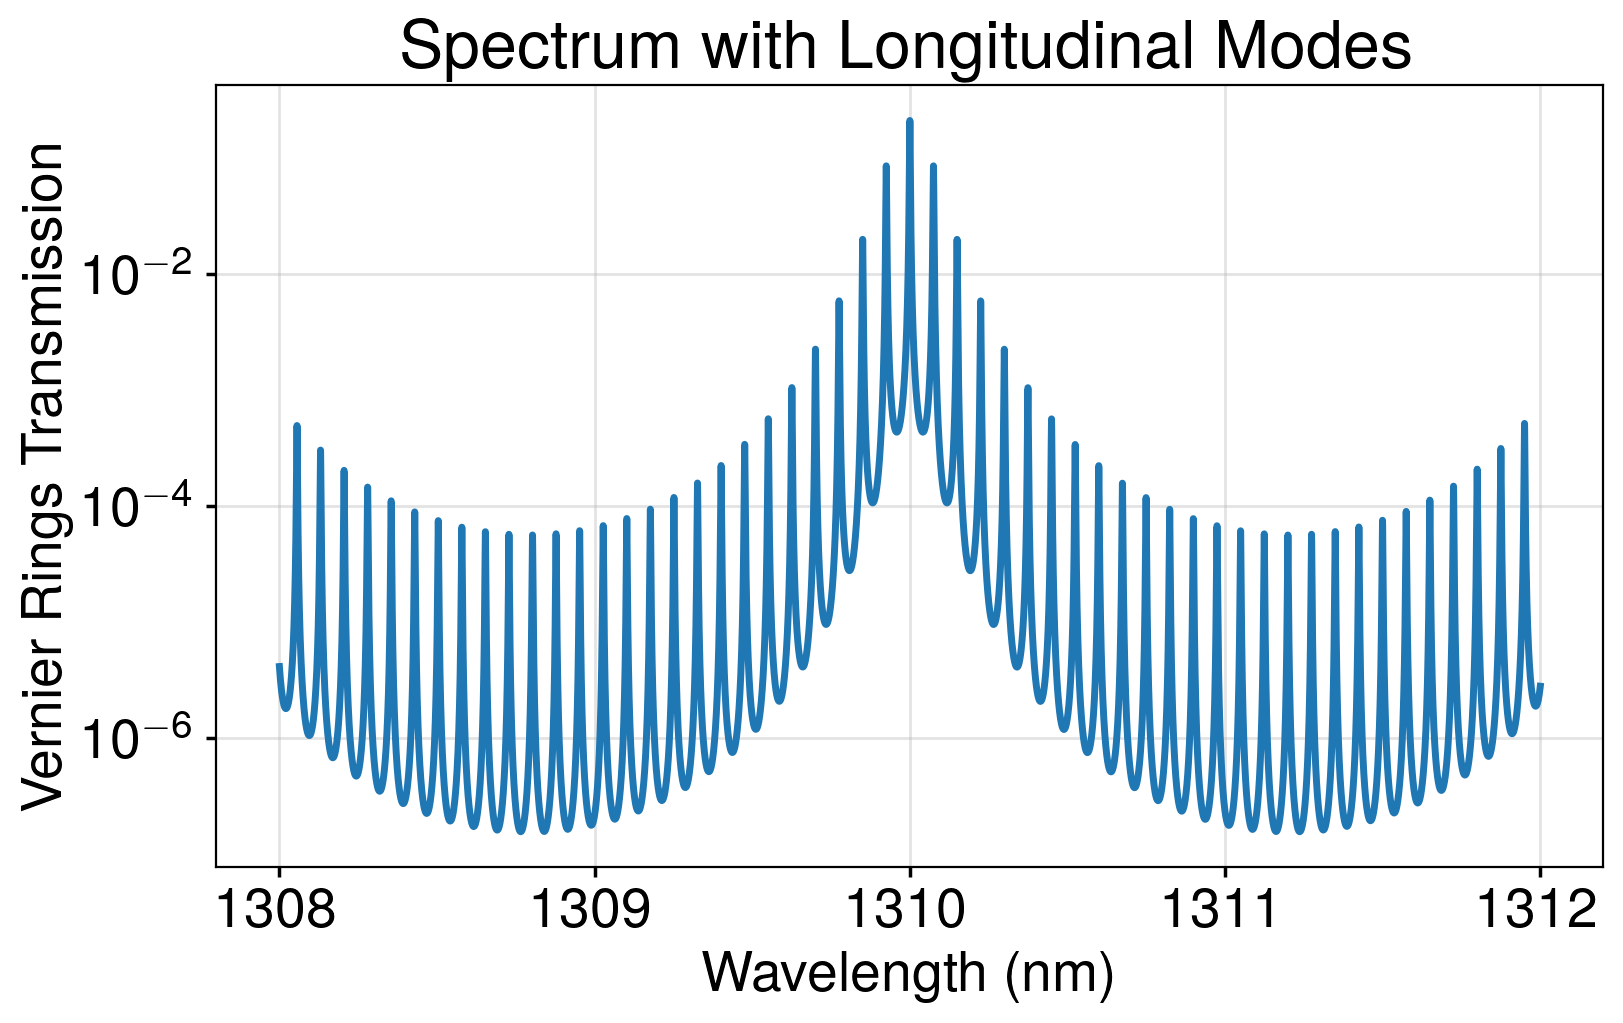

Loss in dB:  -6.766172674623783
Ring Q:  6469.055607517436
Ring FSR:  2.5051228077982227e-09
Ring Finesse:  12.370823471226654


In [11]:
tmp = Vernier_rings_in_longitudinal_cavity(L_long=4e-3,kappa_squared=0.16,radius1=40e-6,radius2=1.1*40e-6)
tmp.Pwaveguide = 1e-3
num_points = 500000
wav, amp = tmp.Vernier_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum of Just Vernier Rings")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1308e-9,lambda_stop=1312e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

print("Loss in dB: ", 10*np.log10(np.max(amp)))

print("Ring Q: ",tmp.ring1.Q())
print("Ring FSR: ",tmp.ring1.FSR())
print("Ring Finesse: ",tmp.ring1.Finesse())

# 5mm Longitudinal Vernier Ring Mirror design

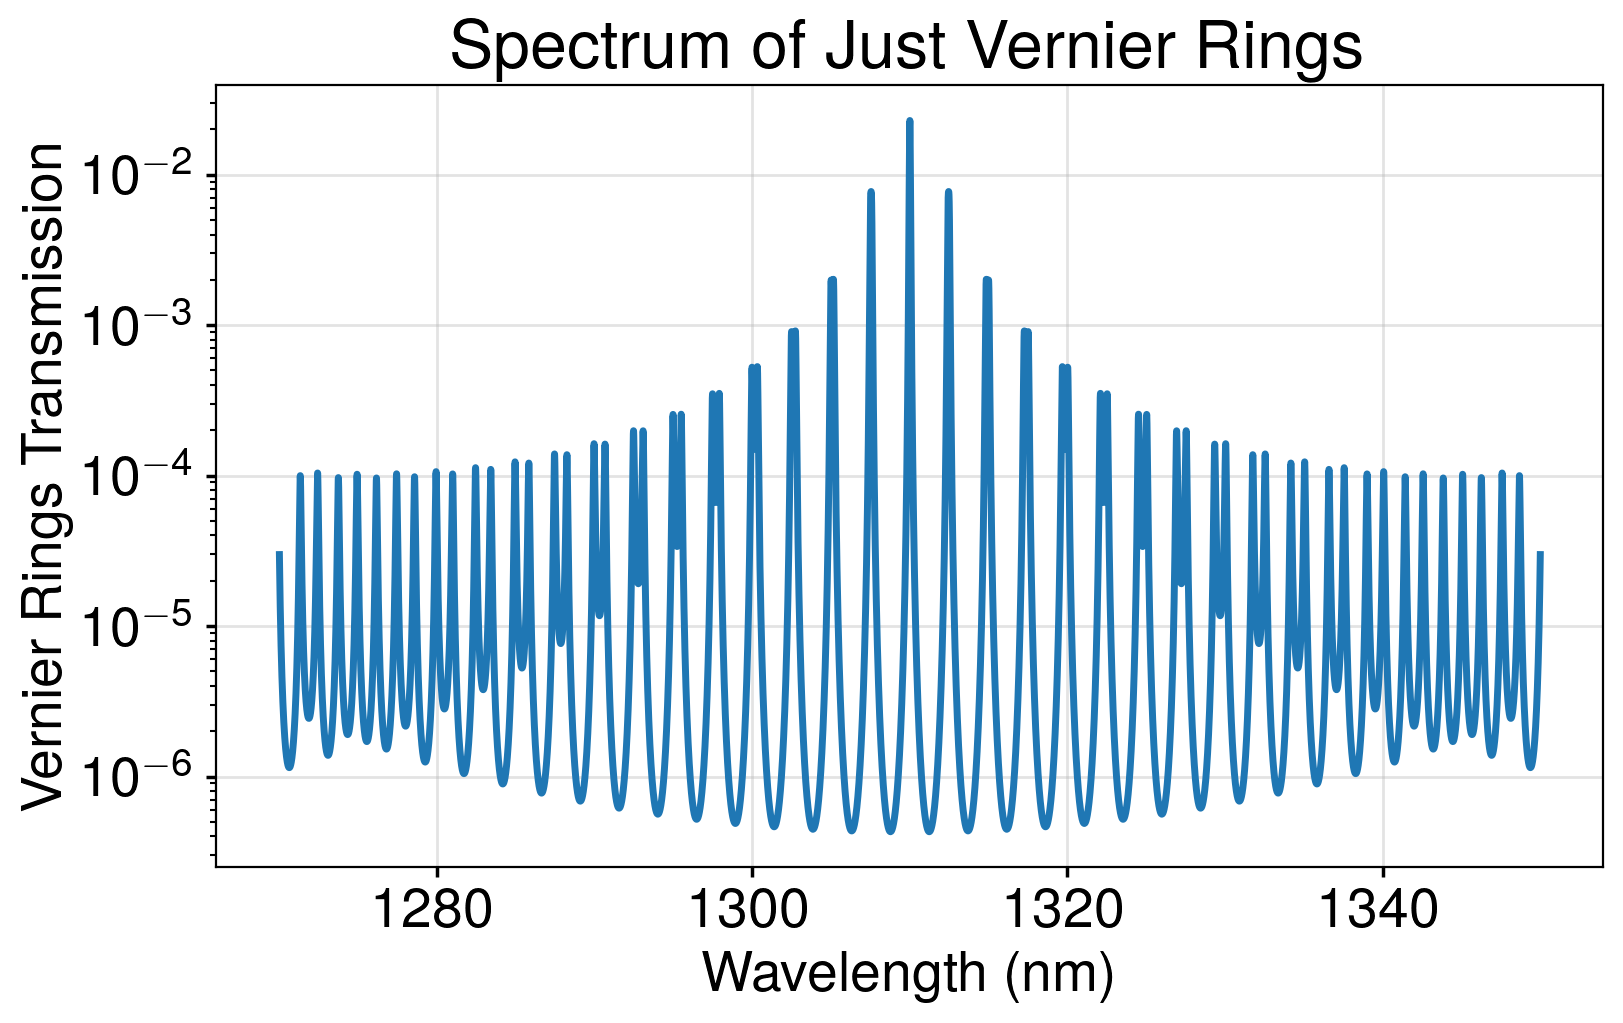

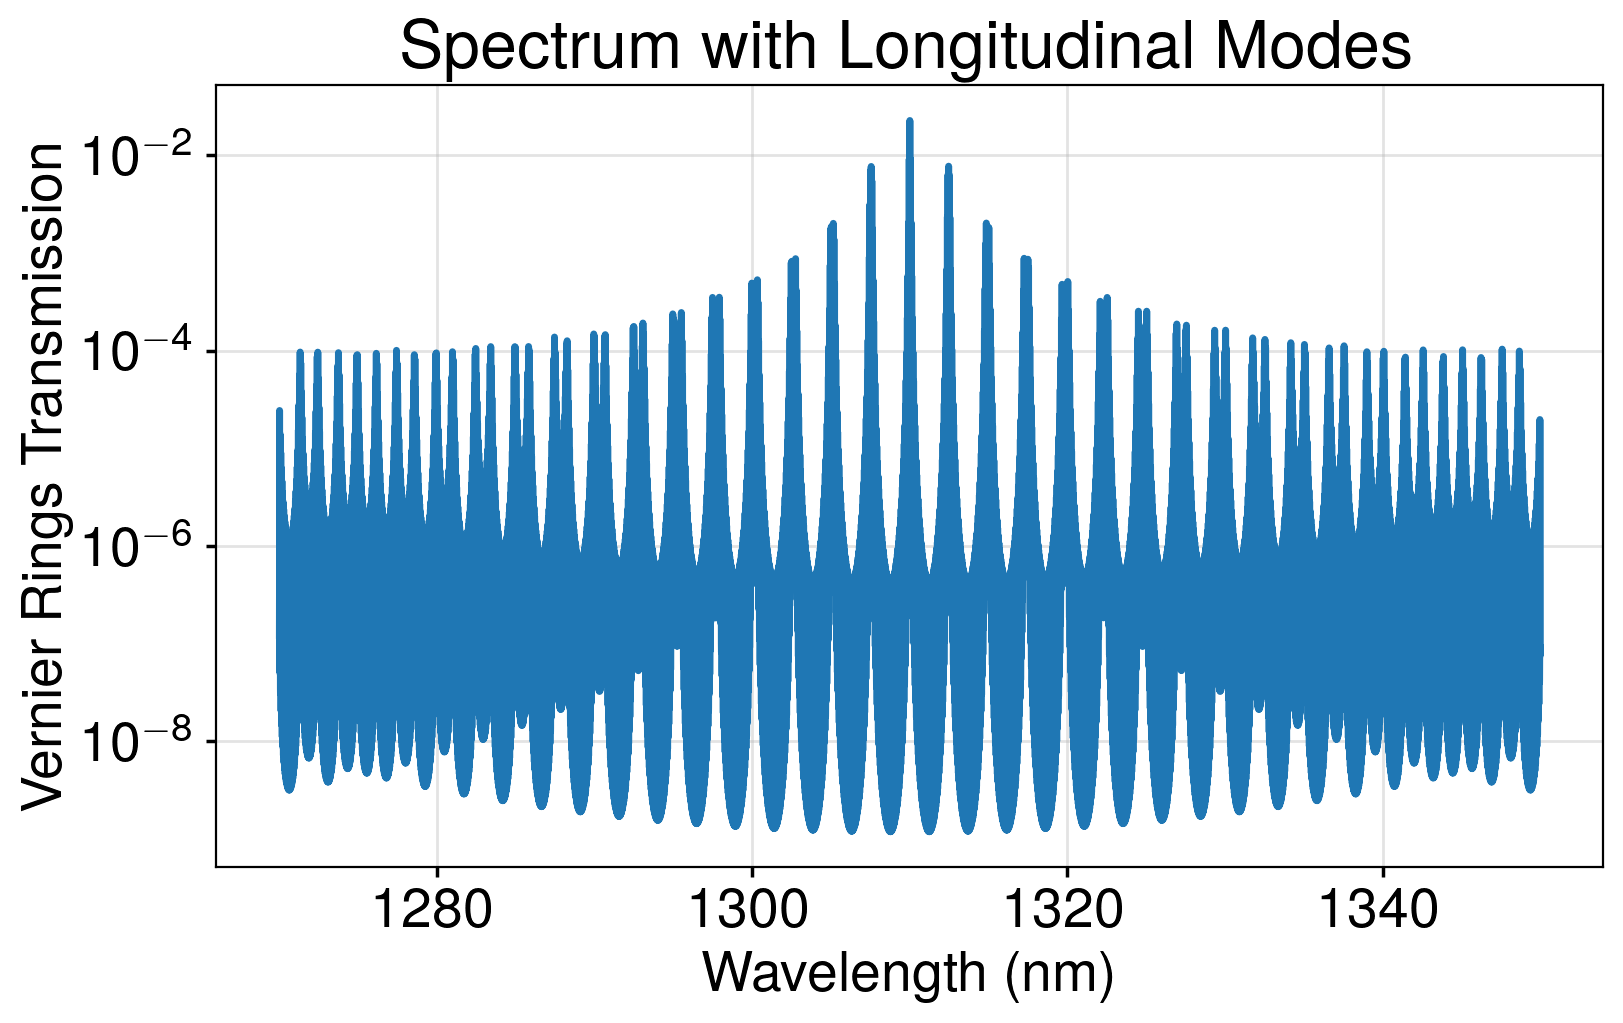

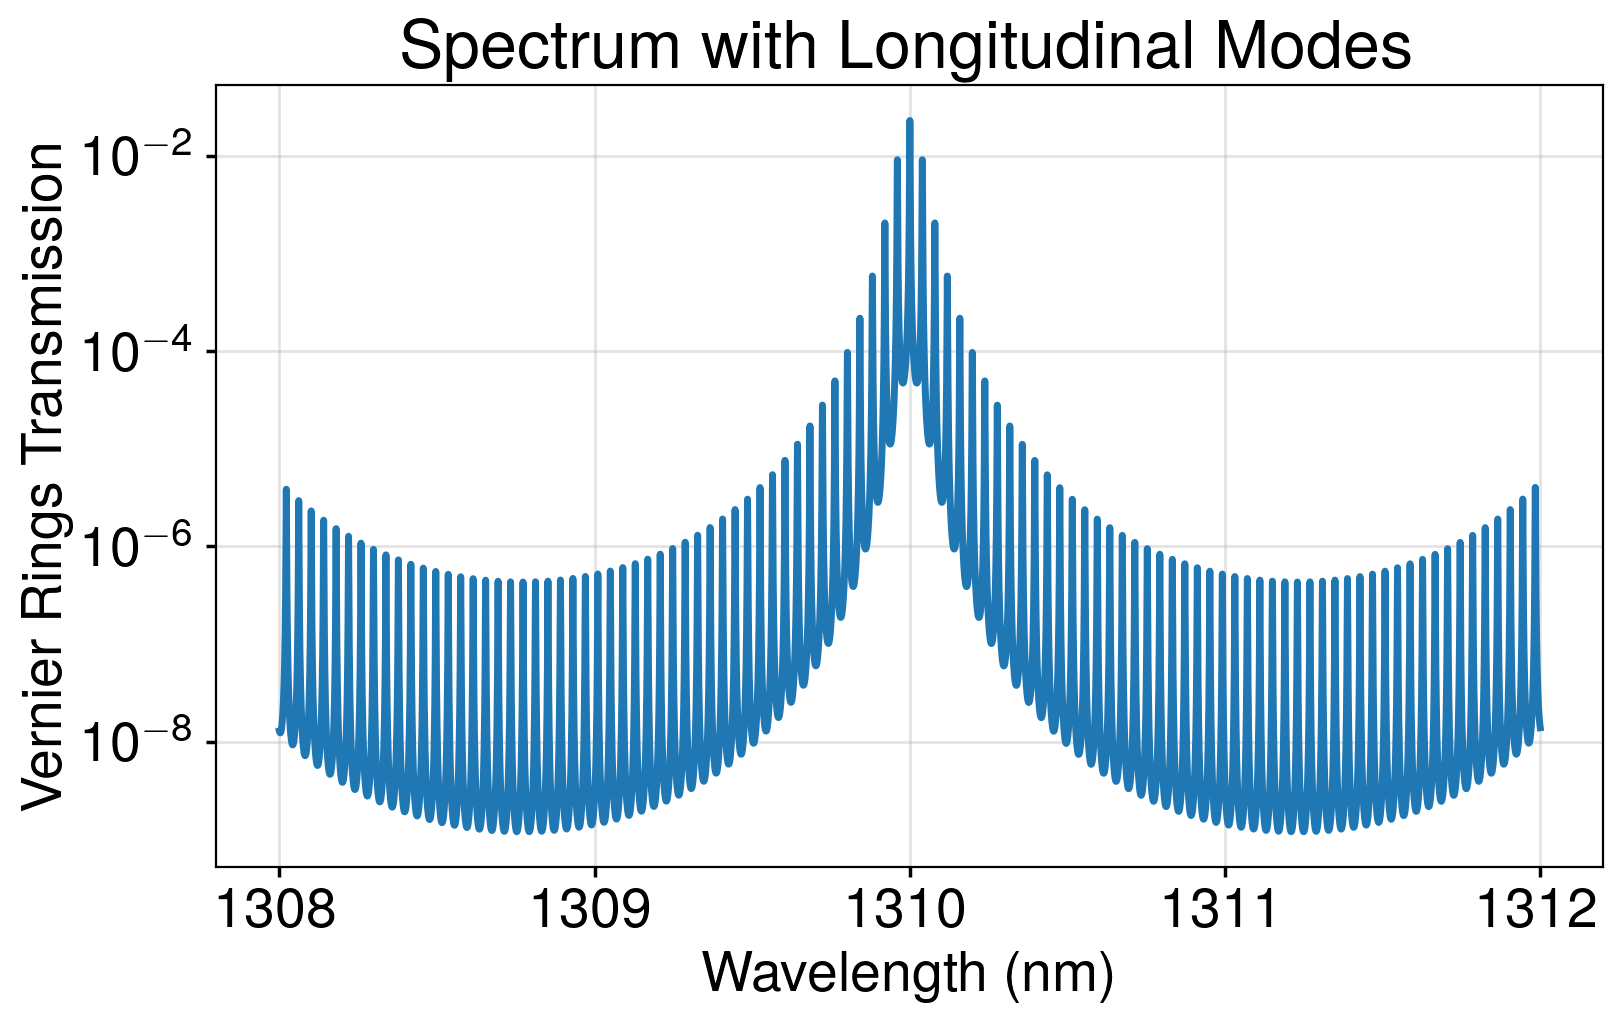

Loss in dB:  -16.402916738617883
Ring Q:  12636.47998854257
Ring FSR:  2.5051228077982227e-09
Ring Finesse:  24.16483528975864


In [7]:
tmp = Vernier_rings_in_longitudinal_cavity(L_long=5e-3,kappa_squared=0.05,radius1=40e-6,radius2=1.05*40e-6)
num_points = 500000
wav, amp = tmp.Vernier_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum of Just Vernier Rings")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1308e-9,lambda_stop=1312e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

print("Loss in dB: ", 10*np.log10(np.max(amp)))

print("Ring Q: ",tmp.ring1.Q())
print("Ring FSR: ",tmp.ring1.FSR())
print("Ring Finesse: ",tmp.ring1.Finesse())

# 6mm Longitudinal Vernier Ring Mirror design

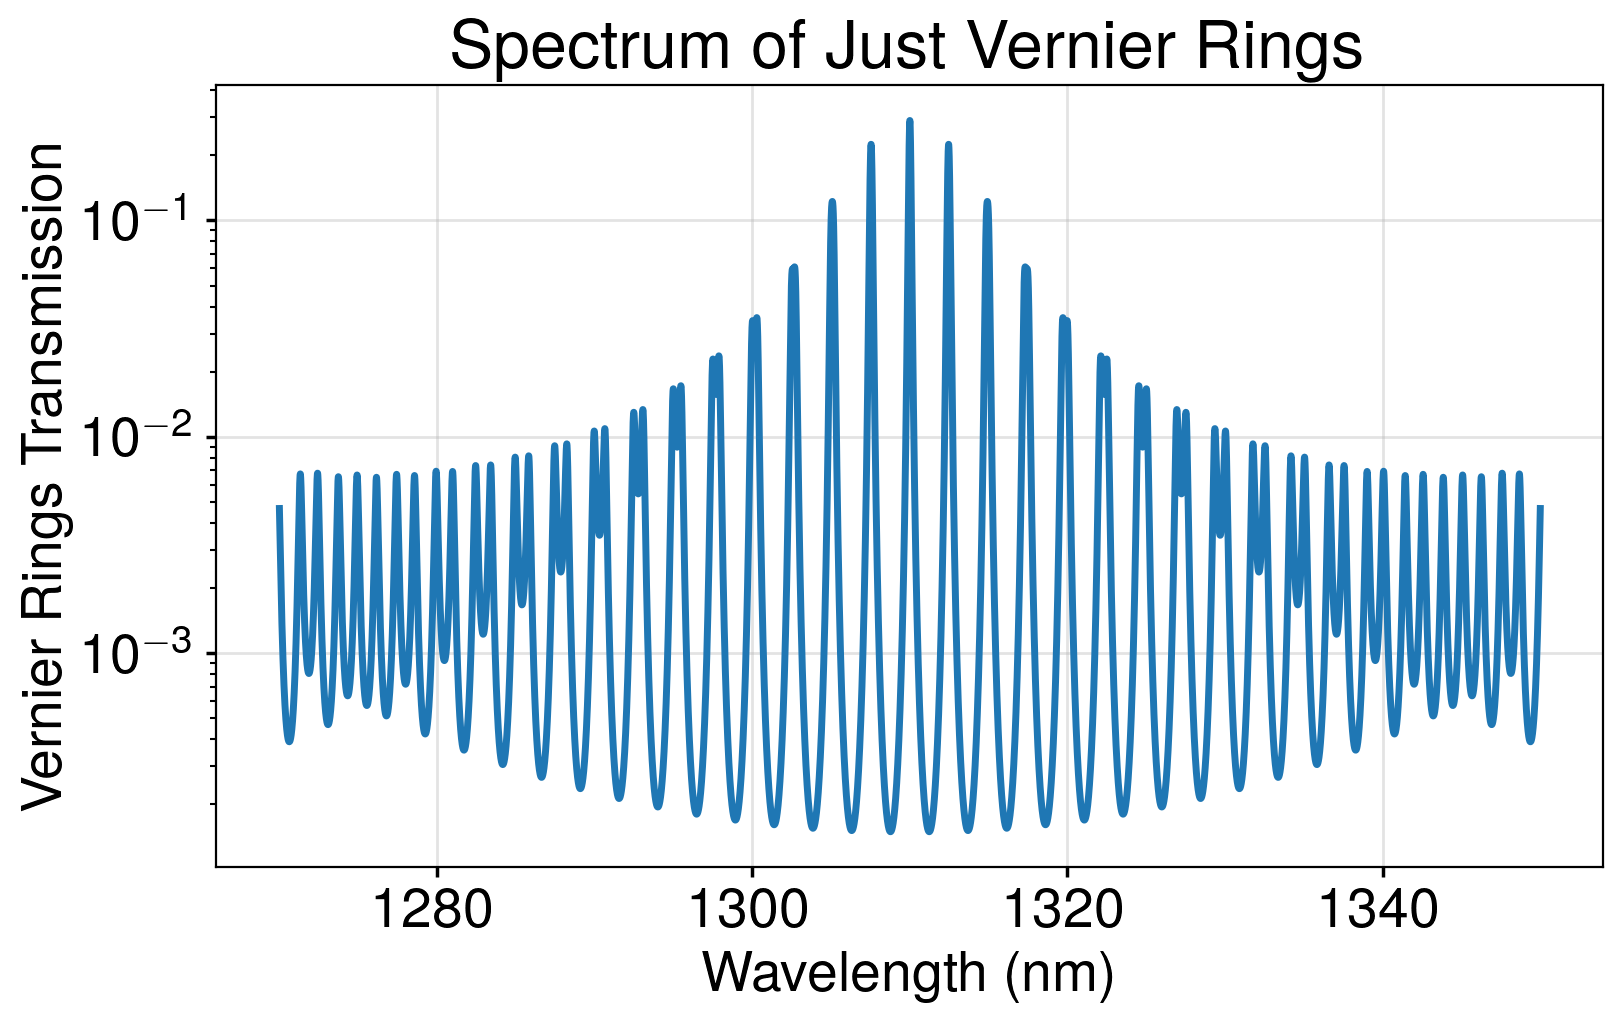

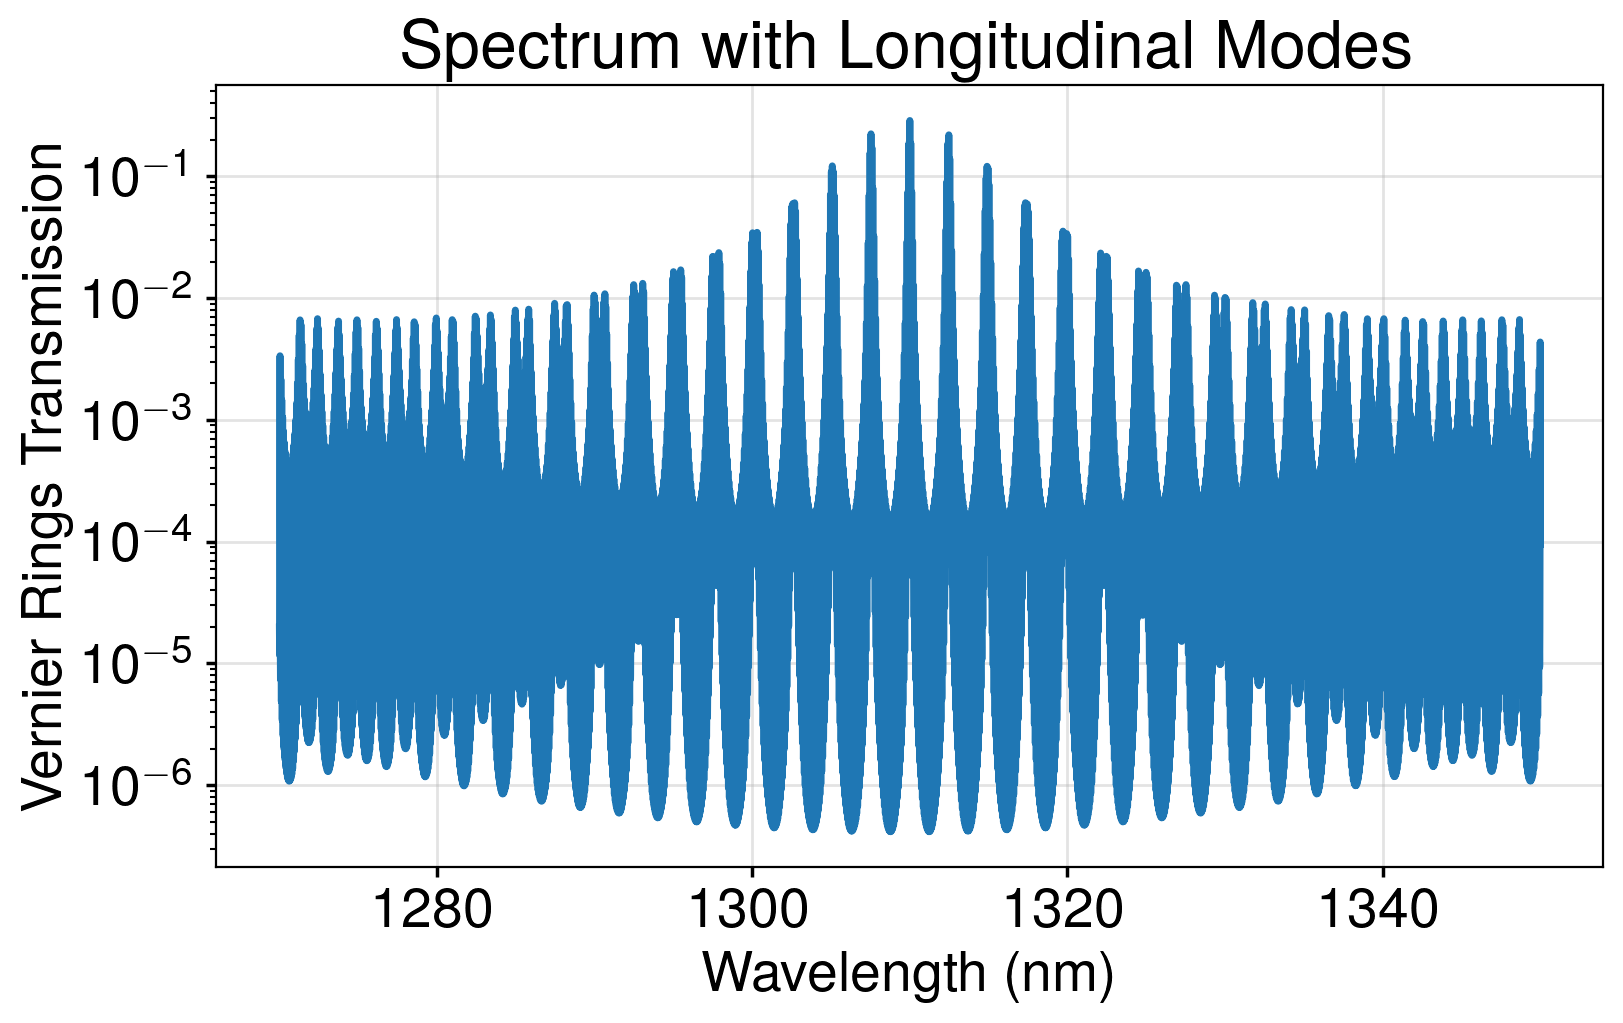

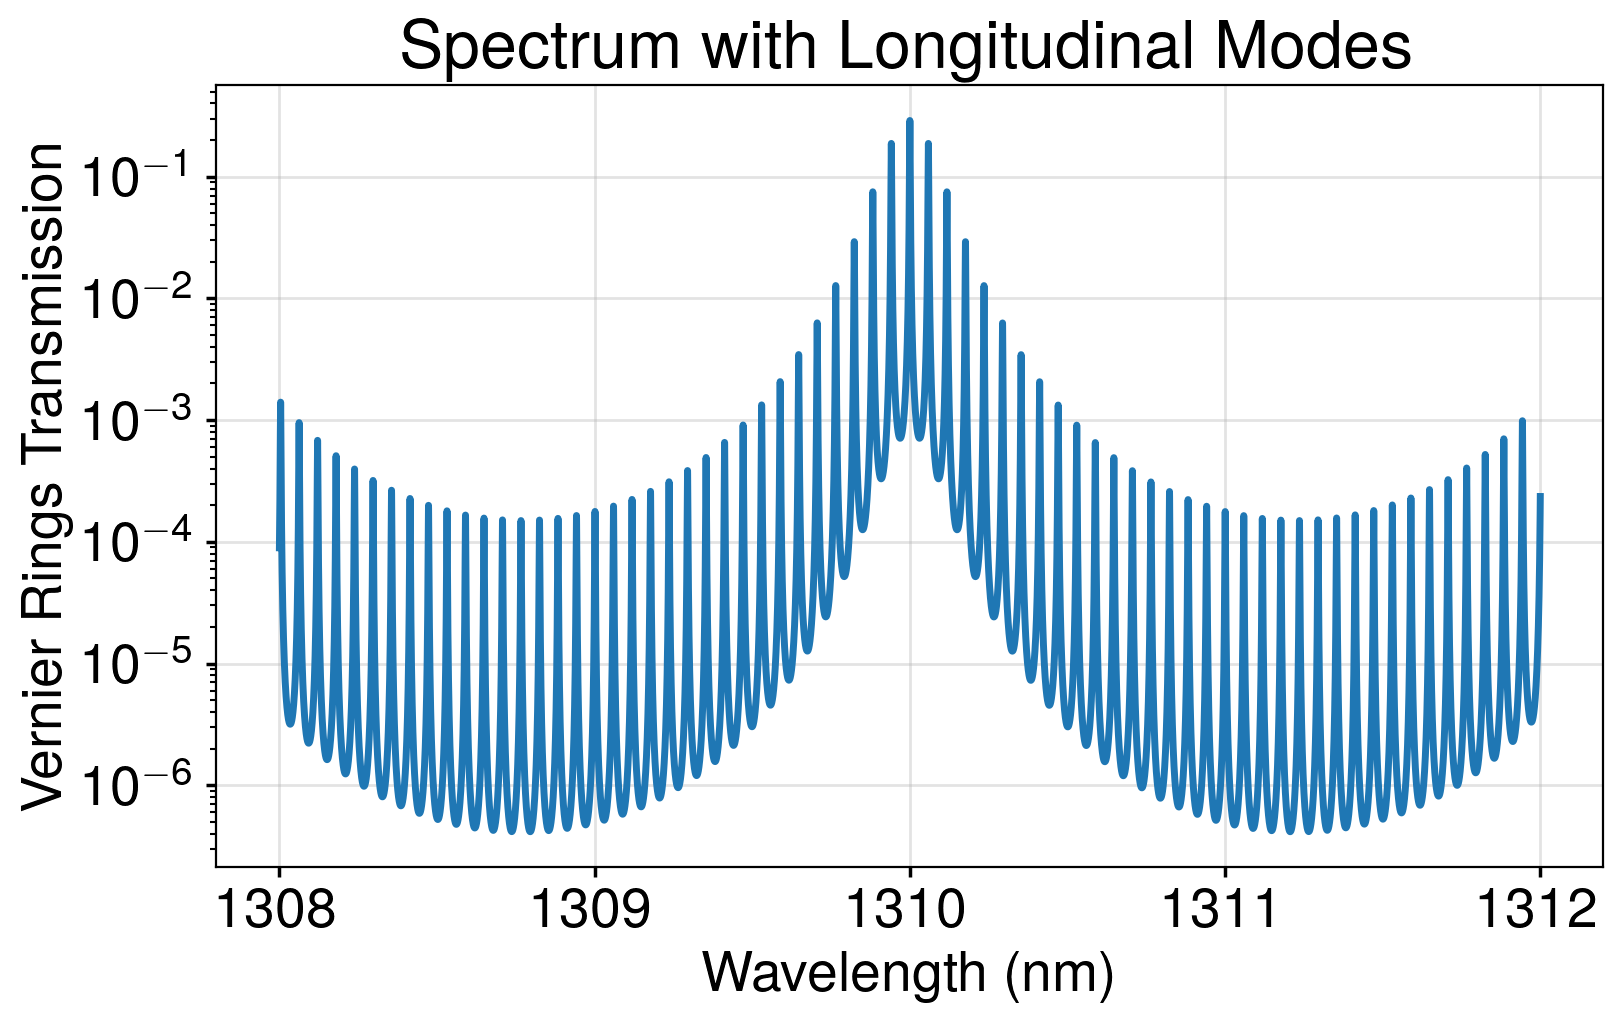

Loss in dB:  -5.381877766101324
Ring Q:  5423.435781269184
Ring FSR:  2.5051228077982227e-09
Ring Finesse:  10.371276849073594


In [8]:
tmp = Vernier_rings_in_longitudinal_cavity(L_long=6e-3,kappa_squared=0.2,radius1=40e-6,radius2=1.05*40e-6)
num_points = 500000
wav, amp = tmp.Vernier_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum of Just Vernier Rings")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1270e-9,lambda_stop=1350e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

wav, amp = tmp.Vernier_with_longitudinal_wavelength_sweep(lambda_start=1308e-9,lambda_stop=1312e-9,num=num_points)
plt.figure()
plt.semilogy(wav*1e9,amp)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Vernier Rings Transmission")
plt.title("Spectrum with Longitudinal Modes")
plt.show()

print("Loss in dB: ", 10*np.log10(np.max(amp)))

print("Ring Q: ",tmp.ring1.Q())
print("Ring FSR: ",tmp.ring1.FSR())
print("Ring Finesse: ",tmp.ring1.Finesse())

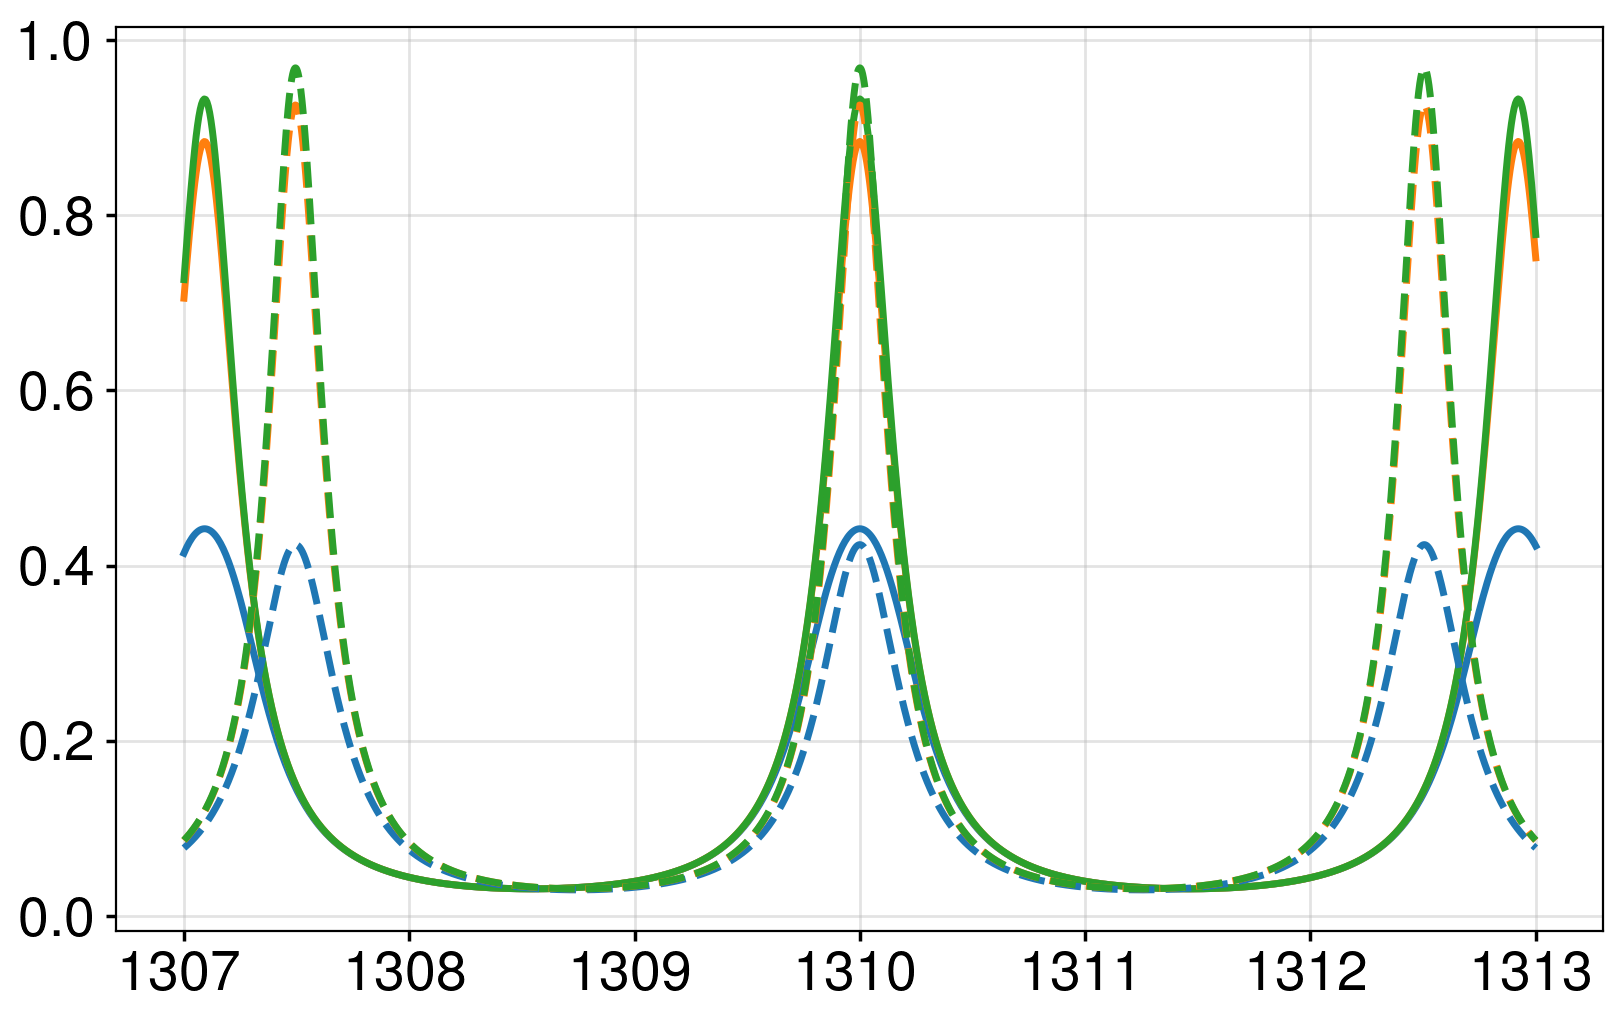

In [9]:
#Compare single ring spectrum with NLA vs cadence measured data to compare simulation methods
import pandas as pd 

data = pd.read_csv("Model_Data/xps_nitride_spectrum_NLA.csv").to_numpy()

tmp  = SiN_XPS_add_drop_ring_resonator(0.3,40e-6,39.1)

# cadence_powers = [1e-1,1e-2,1e-3,1e-4,1,1e-8]
cadence_powers = [0.1, 0.01, 0.001]
plt.figure()

for i in range(len(cadence_powers)):
    plt.plot(data[:,2*i + 0]*1e9,data[:,2*i + 1]/cadence_powers[i],c=f'C{i}')
for index,Pin in enumerate(cadence_powers):
    tmp.Pwaveguide = Pin
    wav,amp = tmp.wavelength_sweep(1307e-9,1313e-9,num=int(1e6))
    plt.plot(wav*1e9,amp,c=f"C{index}",linestyle='--')
plt.show()
